In [2]:
# import sys
# sys.path.append('./../gp_sinkhorn/')
from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.utils import plot_trajectories_2
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn import MLE_drift

import copy
import torch
import math
import numpy as np

from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

#  IPFP

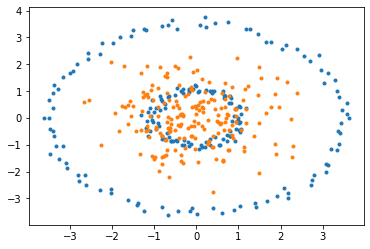

In [2]:
device="cpu"
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))

num_samples = 30

import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
n = 200
n_2 = int(n * 1.0 / 3)
# n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(2 * n).reshape(-1,2) - 0
X2, _ =  make_circles(n_samples=n, factor=0.3, noise=0.03)
X2 *= 3.5
# X1, X2 = X2, X1

plt.plot(X2[:,0], X2[:,1], '.')
plt.plot(X1[:,0], X1[:,1], '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).to(device)
    X2 = torch.tensor(X2).to(device)
X_12 = torch.cat((X1,X2))

In [1]:
result = MLE_IPFP(X1,X2,prior_X_0=X_12, N=N)

In [ ]:
def plot_trajectories_both_3d(Xts,t , Xts_, t_, name=None):

    fn = 14
    fig = plt.figure(figsize=(15,10))
    
    n = Xts.shape[0]
    
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_xlabel("$t$", fontsize=fn)
    ax.set_ylabel("$x(t)$", fontsize=fn)
    ax.set_zlabel("$y(t)$", fontsize=fn)
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        ti, xi = t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy()
        ax.plot(ti, xi[:,0], xi[:,1],  'b', alpha=0.3,  label=label)
    
    
    ax.legend(fontsize=fn)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    tt = ax.get_xticks()
    ax.set_xlabel("$t$", fontsize=fn)
    ax.set_ylabel("$x(t)$", fontsize=fn)
    ax.set_zlabel("$y(t)$", fontsize=fn)
    
    n = Xts_.shape[0]
    
    ax.set_xticks(tt.flatten() )
    ax.set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        ti, xi = t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy()
        ax.plot(ti, xi[:,0], xi[:,1], 'r', alpha=0.3, label=label)

    ax.legend(fontsize=fn)
    
    if name is not None:
        plt.savefig(name)
    plt.show() 

T,M,T2,M2 = result[-1]
plot_trajectories_both_3d(M,T, M2, T2)

# 2D example

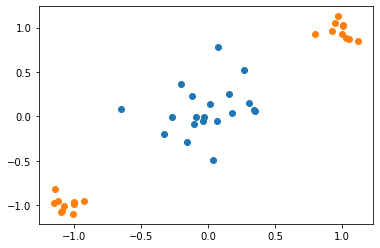

In [32]:
num_samples = 10
N = 100
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)*0.05).sample((num_samples*2,1)).reshape((-1,2))

X_1_a = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2),torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1_b = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2)*-1,torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1 = torch.cat((X_1_a,X_1_b))

# TO reshape
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])


In [33]:
result = MLE_IPFP(X_0,X_1,N=N,sigma=0.3, iteration=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.34s/it]


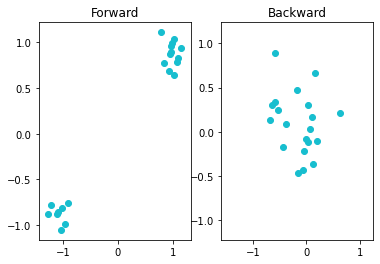

In [35]:
fig, (ax1, ax2) =  plt.subplots(1, 2)
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')
